In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
##
## 1. Data ingest and data cleaning
##

df = pd.read_csv("flights.csv", low_memory=False)

In [3]:
df = df[df["MONTH"] == 11]
df.shape

(467972, 31)

In [4]:
print(df.dtypes)
print(df.head())

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object
         YEAR  MONTH  DAY

In [5]:
# import datetime
# dt = np.empty(df.shape[0], dtype = datetime.date)
# for i in range(0, df.shape[0]):
#     dt[i] = datetime.date(df.YEAR[i], df.MONTH[i], df.DAY[i])
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [6]:
df['DATE'].head()

4871877   2015-11-01
4871878   2015-11-01
4871879   2015-11-01
4871880   2015-11-01
4871881   2015-11-01
Name: DATE, dtype: datetime64[ns]

In [7]:
# format date

def format_time(data):
    if pd.isnull(data): return np.nan
    else:
        if data == 2400: data = 0
        data = "{0:04d}".format(int (data))
        return datetime.time(int (data[0:2]),int (data[2:4]))

In [8]:
# Get necessary records

df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].apply(format_time)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_time)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_time)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_time)

df = df.loc[:,['DATE',
                       'AIRLINE',
                       'ORIGIN_AIRPORT',
                       'DESTINATION_AIRPORT',
                       'SCHEDULED_DEPARTURE',
                       'SCHEDULED_ARRIVAL',
                       'DEPARTURE_TIME',
                       'DEPARTURE_DELAY',
                       'ARRIVAL_TIME',
                       'ARRIVAL_DELAY',
                       'SCHEDULED_TIME',
                       'ELAPSED_TIME']]
df.head()

,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
4871877,2015-11-01,NK,LAS,MSP,00:05:00,04:02:00,00:07:00,2.0,04:04:00,2.0,177.0,177.0
4871878,2015-11-01,UA,SFO,ORD,00:14:00,05:32:00,00:19:00,5.0,05:10:00,-22.0,258.0,231.0
4871879,2015-11-01,AA,LAX,MIA,00:15:00,07:11:00,00:06:00,-9.0,07:19:00,8.0,296.0,313.0
4871880,2015-11-01,UA,LAX,ORD,00:31:00,05:39:00,00:27:00,-4.0,05:18:00,-21.0,248.0,231.0
4871881,2015-11-01,UA,LAS,IAH,00:41:00,04:33:00,NaN,NaN,NaN,NaN,172.0,NaN


In [9]:
## show the portion of missing value

col1 = df.columns
col2 = df.isnull().sum()
col3 = (1 - col2 / len(df)) * 100

missing_df = pd.DataFrame({"variable":col1, "missing values":col2, "filling factor (%)":col3})
# missing_df.sort_values('filling factor (%)').reset_index(drop = True)
missing_df

,variable,missing values,filling factor (%)
DATE,DATE,0,100.000000
AIRLINE,AIRLINE,0,100.000000
ORIGIN_AIRPORT,ORIGIN_AIRPORT,0,100.000000
DESTINATION_AIRPORT,DESTINATION_AIRPORT,0,100.000000
SCHEDULED_DEPARTURE,SCHEDULED_DEPARTURE,0,100.000000
SCHEDULED_ARRIVAL,SCHEDULED_ARRIVAL,0,100.000000
DEPARTURE_TIME,DEPARTURE_TIME,4339,99.072808
DEPARTURE_DELAY,DEPARTURE_DELAY,4339,99.072808
ARRIVAL_TIME,ARRIVAL_TIME,4817,98.970665
ARRIVAL_DELAY,ARRIVAL_DELAY,5605,98.802279


In [10]:
df.dropna(inplace = True)
df.head()

,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
4871877,2015-11-01,NK,LAS,MSP,00:05:00,04:02:00,00:07:00,2.0,04:04:00,2.0,177.0,177.0
4871878,2015-11-01,UA,SFO,ORD,00:14:00,05:32:00,00:19:00,5.0,05:10:00,-22.0,258.0,231.0
4871879,2015-11-01,AA,LAX,MIA,00:15:00,07:11:00,00:06:00,-9.0,07:19:00,8.0,296.0,313.0
4871880,2015-11-01,UA,LAX,ORD,00:31:00,05:39:00,00:27:00,-4.0,05:18:00,-21.0,248.0,231.0
4871882,2015-11-01,AS,ANC,SEA,00:45:00,04:06:00,00:42:00,-3.0,03:58:00,-8.0,201.0,196.0


In [11]:
##
## 2. Comparing Airlines
##

airlines_names = pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [12]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()
len(abbr_companies)

14

In [13]:
# Because there was no 'US' in the November data, so it is removed
del abbr_companies['US']

In [14]:
def get_stats(group):
    return {'min': group.min(), 'max':group.max(),'count': group.count(), 'mean':group.mean()}
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,min
AIRLINE,,,,
VX,5345.0,288.0,5.742376,-24.0
HA,6012.0,332.0,-1.841317,-26.0
F9,7713.0,918.0,11.607935,-32.0
NK,10050.0,476.0,8.615224,-29.0
AS,13871.0,634.0,1.652368,-48.0
MQ,19331.0,931.0,6.979877,-25.0
B6,21542.0,510.0,7.085136,-31.0
EV,41644.0,993.0,7.051628,-38.0
UA,42236.0,1142.0,11.195284,-20.0


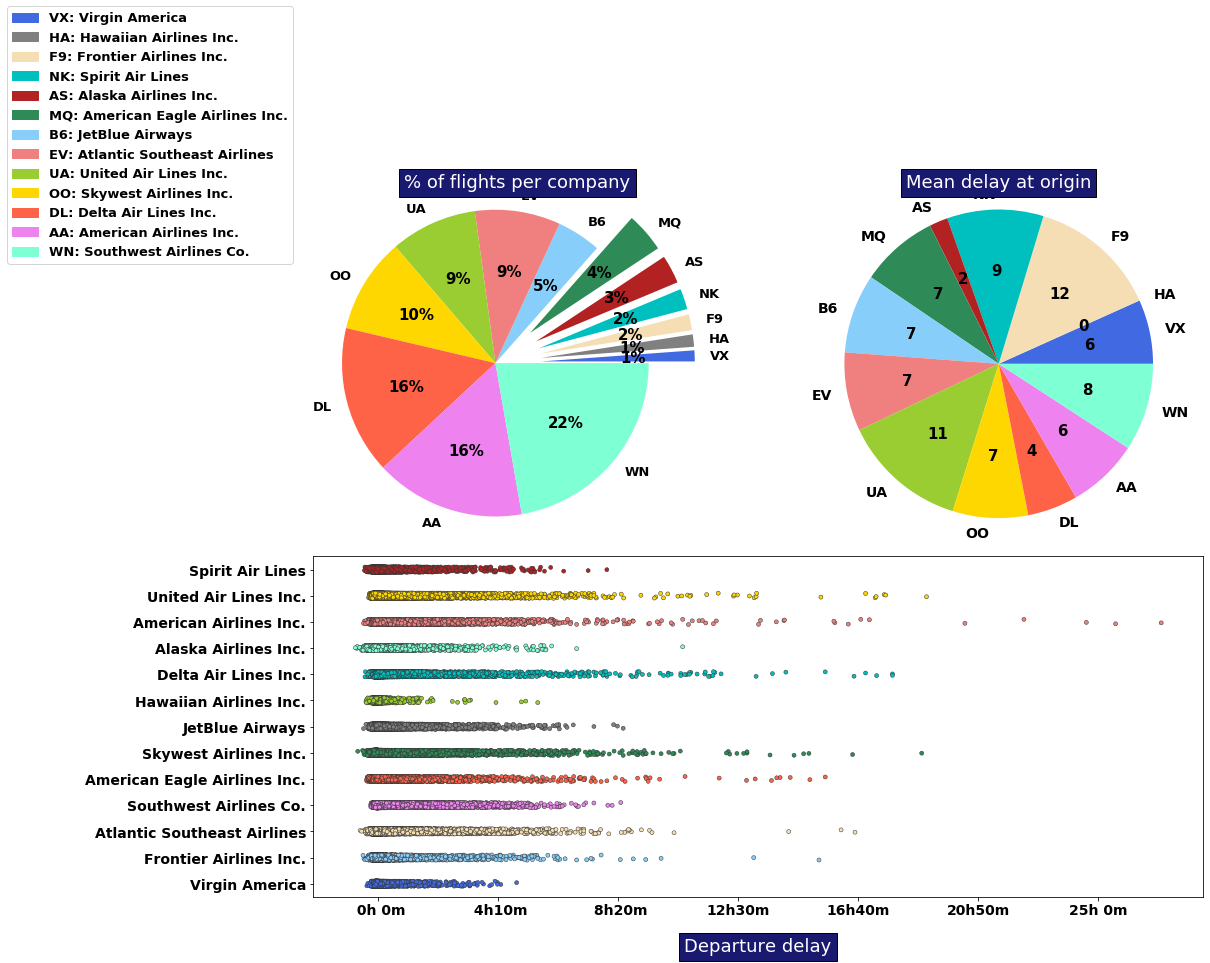

In [15]:
import matplotlib.patches as mpatches
font = { 'family': 'DejaVu Sans','weight' : 'bold', 'size' : 15}
mpl.rc('font', **font)

# extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(13)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#------------------------------
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3)

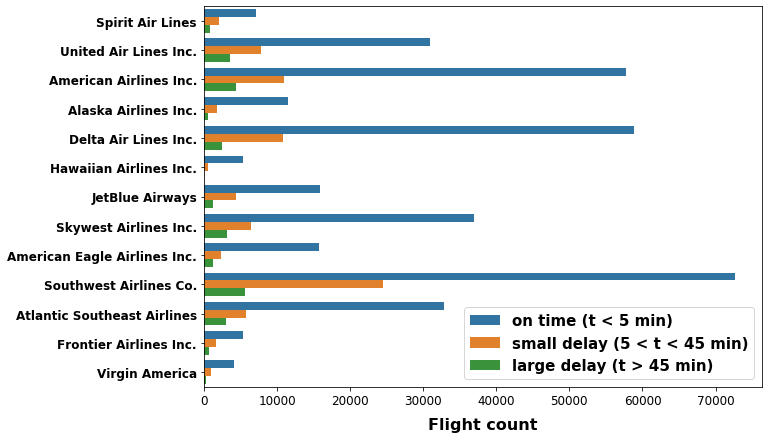

In [16]:
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)

fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)

# Replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

D:\Coding\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


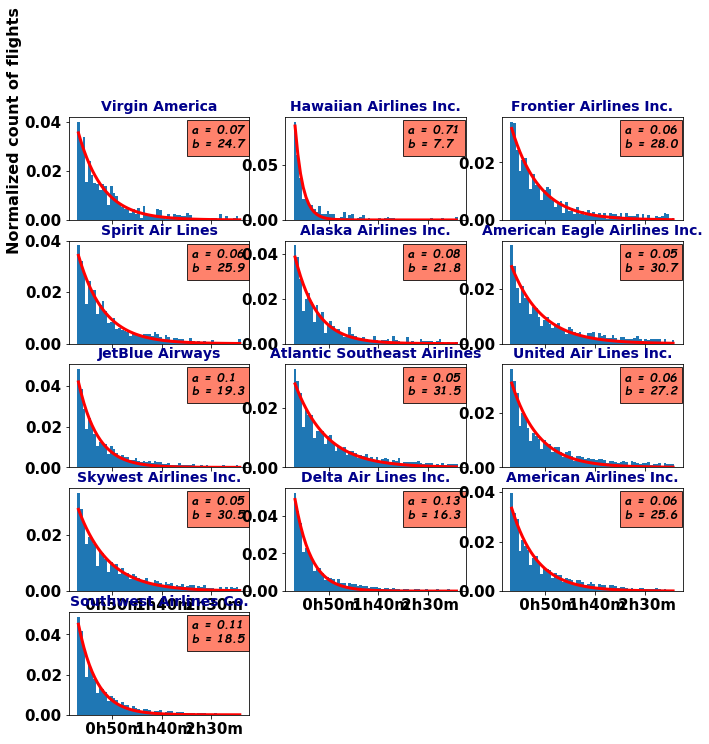

In [17]:
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), density=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
        
# Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

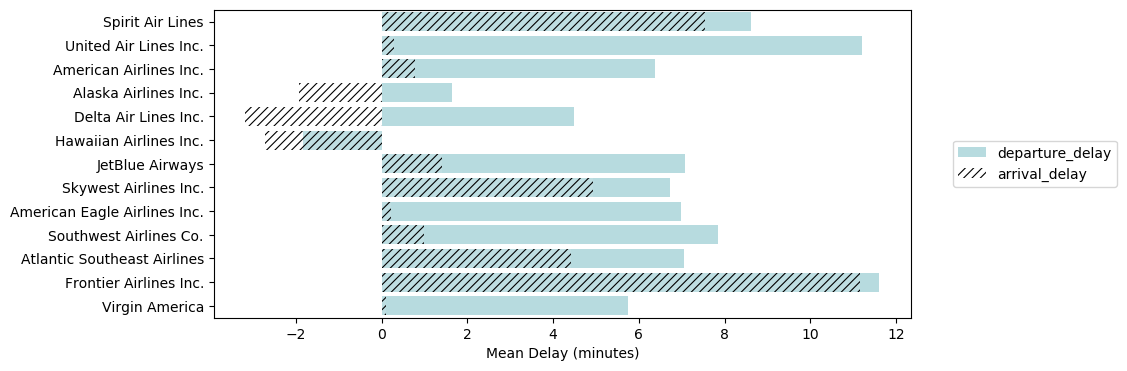

In [18]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 0.8

fig = plt.figure(1, figsize = (9, 4))
ax = sns.barplot(x = 'DEPARTURE_DELAY', y = 'AIRLINE', data = df, color = 'powderblue', ci = None, label = 'departure_delay')
ax = sns.barplot(x = 'ARRIVAL_DELAY', y = 'AIRLINE', data = df, color = 'white', hatch = '////', alpha = 0.1, ci = None, label = 'arrival_delay')
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean Delay (minutes)')
plt.legend(loc = 'center left', bbox_to_anchor = (1.05, 0.5))
plt.show()

In [19]:
# Take UA as an example
carrier = 'AA'
id_airport = 4
temp = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT']
liste_origin_airport = temp.unique()
print(liste_origin_airport)
df2 = df[(df['AIRLINE'] == carrier) & (df['ARRIVAL_DELAY'] > 0)
         & (df['ORIGIN_AIRPORT'] == liste_origin_airport[id_airport])]
df2 = df2.sort_values(by = 'SCHEDULED_DEPARTURE')
# df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
df2.head()

['LAX' 'SFO' 'PDX' 'PHX' 'IAH' 'LAS' 'ORD' 'DFW' 'EWR' 'ATL' 'BOS' 'MSP'
 'STL' 'DCA' 'MCO' 'PHL' 'SEA' 'LGA' 'JFK' 'CLE' 'TUL' 'DEN' 'MIA' 'MEM'
 'FAT' 'RDU' 'MSY' 'IAD' 'AUS' 'RNO' 'ONT' 'PBI' 'IND' 'FLL' 'TPA' 'BDL'
 'MCI' 'CMH' 'SAT' 'PSP' 'SMF' 'PVD' 'MFE' 'TUS' 'JAX' 'ABQ' 'BNA' 'SAN'
 'SJC' 'BUF' 'ELP' 'DTW' 'OKC' 'BWI' 'ORF' 'MKE' 'RIC' 'SJU' 'PIT' 'BOI'
 'CLT' 'SLC' 'HNL' 'ILM' 'RSW' 'OMA' 'COS' 'SNA' 'SYR' 'DSM' 'ALB' 'PWM'
 'ROC' 'GEG' 'MDT' 'STT' 'STX' 'CHS' 'DAY' 'OAK' 'OGG' 'GSO' 'LIH' 'SDF'
 'KOA' 'ANC' 'LBB' 'EGE' 'XNA']


,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DELAY_LEVEL
4871911,2015-11-01,AA,IAH,MIA,05:00:00,08:23:00,04:56:00,-4.0,08:36:00,13.0,143.0,160.0,0
5125122,2015-11-17,AA,IAH,DFW,05:00:00,06:13:00,04:59:00,-1.0,06:18:00,5.0,73.0,79.0,0
5305484,2015-11-29,AA,IAH,DFW,05:00:00,06:13:00,04:57:00,-3.0,06:16:00,3.0,73.0,79.0,0
5218858,2015-11-23,AA,IAH,CLT,05:15:00,08:34:00,05:13:00,-2.0,08:42:00,8.0,139.0,149.0,0
4969737,2015-11-07,AA,IAH,MIA,05:15:00,08:39:00,05:18:00,3.0,08:55:00,16.0,144.0,157.0,0


In [20]:
# Part 4 Temporal variability of delays
cd = pd.read_csv('combine_departure.csv', low_memory = False)
cd.dtypes

Unnamed: 0              int64
DATE                   object
AIRLINE                object
ORIGIN_AIRPORT         object
DESTINATION_AIRPORT    object
SCHEDULED_DEPARTURE    object
SCHEDULED_ARRIVAL      object
DEPARTURE_TIME         object
DEPARTURE_DELAY         int64
ARRIVAL_TIME           object
ARRIVAL_DELAY           int64
SCHEDULED_TIME          int64
ELAPSED_TIME            int64
DELAY_LEVEL            object
COMBINE                object
dtype: object

In [21]:
carrier = 'AA'
id_airport = 4
temp1 = cd[cd['AIRLINE'] == carrier]['ORIGIN_AIRPORT']
liste_origin_airport = temp1.unique()
# print(liste_origin_airport)
cd2 = cd[(cd['AIRLINE'] == carrier) & (cd['ARRIVAL_DELAY'] > 0)
         & (cd['ORIGIN_AIRPORT'] == liste_origin_airport[id_airport])]
cd2 = cd2.sort_values(by = 'COMBINE')
# df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
t = cd2['COMBINE']
t = pd.to_datetime(t)

D:\Coding\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


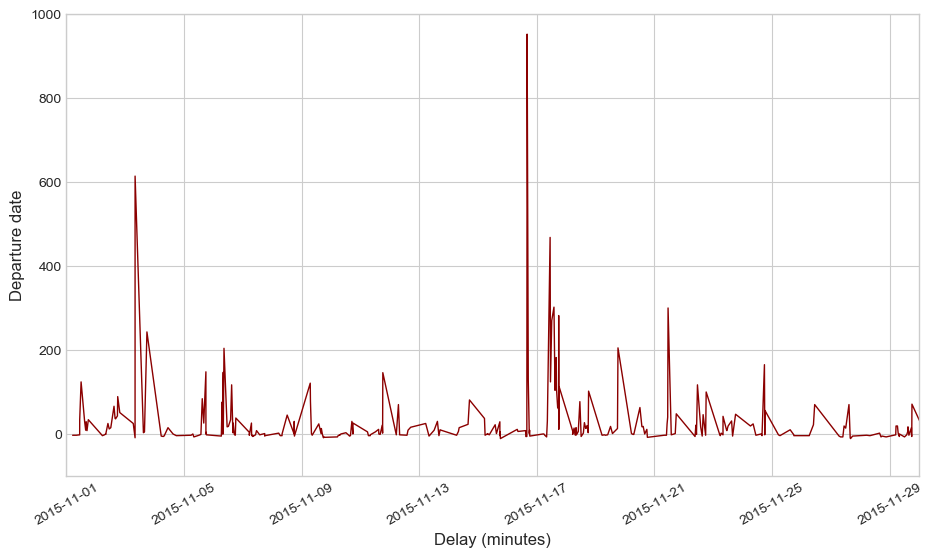

In [22]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [11.0, 6.0]
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.plot(t, cd2['DEPARTURE_DELAY'], color = 'darkred', linewidth = 1)
# plt.plot(df2['SCHEDULED_DEPARTURE'], df2['DEPARTURE_DELAY'], linewidth = 0.8)
plt.xlabel('Delay (minutes)', fontsize = 12)
plt.ylabel('Departure date', fontsize = 12)
plt.xticks(rotation = 30)
plt.xlim(datetime.datetime(2015, 11, 1), datetime.datetime(2015, 11, 30))
plt.ylim(-100, 1000);

In [25]:
##
## Relation between the origin airport and delays
##

len(df['ORIGIN_AIRPORT'].unique())


305

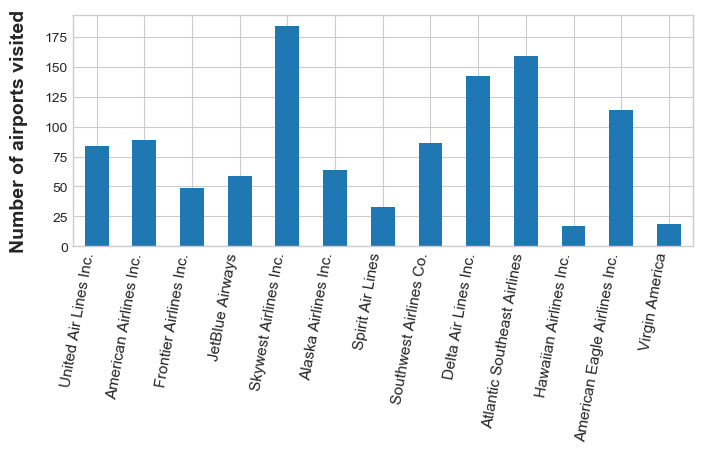

In [26]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [10]:
##
## part6 Predict Flight Delays
## 
from sklearn.metrics import confusion_matrix

In [11]:
df_clean = pd.read_csv("filghts_data_clean.csv", low_memory=False)
df_clean = df_clean.drop(["MONTH", "ARRIVAL_TIME","ARRIVAL_DELAY","DEPARTURE_TIME","SCHEDULED_ARRIVAL", "ELAPSED_TIME"], axis = 1)

In [12]:
df_clean.head()


,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_TIME
0,1,NK,LAS,MSP,0,2,177
1,1,UA,SFO,ORD,0,5,258
2,1,AA,LAX,MIA,0,-9,296
3,1,UA,LAX,ORD,0,-4,248
4,1,AS,ANC,SEA,0,-3,201


In [13]:
df_clean["DEPARTURE_DELAY"] = df_clean["DEPARTURE_DELAY"].map(lambda x: 1 if x > 15 else 0)
df_clean.head()

,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_TIME
0,1,NK,LAS,MSP,0,0,177
1,1,UA,SFO,ORD,0,0,258
2,1,AA,LAX,MIA,0,0,296
3,1,UA,LAX,ORD,0,0,248
4,1,AS,ANC,SEA,0,0,201


In [14]:
df_clean = pd.get_dummies(df_clean, columns=['DATE', 'AIRLINE', 'ORIGIN_AIRPORT','DESTINATION_AIRPORT'])
df_clean.head()
df_clean.shape

(462367, 656)

Class 0:  395823
Class 1:  66544
Proportion is:  5.948289853330127


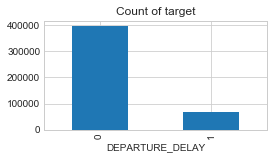

In [15]:
# Balance the data of class

# 1. How unbalanced the dataset is:
freq = df_clean.groupby('DEPARTURE_DELAY').size()
print('Class 0: ', freq[0])
print('Class 1: ', freq[1])
print('Proportion is: ', freq[0]/freq[1])
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [4, 2]
freq.plot(kind = 'bar', title = 'Count of target');

After random under-sampling: 
Class 0:  66544
Class 1:  66544
Proportion is:  1.0


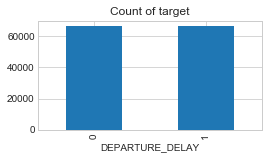

In [16]:
# For handling unbalanced data, we could:
# 1. remove samples from the majority calss(under sampling)
# 2. Add more examples from the minority class(over sampling)

# We use under sampling.
count_class_0, count_class_1 = freq
df_class_0 = df_clean[df_clean['DEPARTURE_DELAY'] == 0]
df_class_1 = df_clean[df_clean['DEPARTURE_DELAY'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis = 0)
freq = df_test_under.groupby('DEPARTURE_DELAY').size()
print('After random under-sampling: ')
print('Class 0: ', freq[0])
print('Class 1: ', freq[1])
print('Proportion is: ', freq[0]/freq[1])
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [4, 2]
freq.plot(kind = 'bar', title = 'Count of target');
df_clean = df_test_under

In [17]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df_clean.drop('DEPARTURE_DELAY', axis=1), df_clean['DEPARTURE_DELAY'], test_size=0.2, random_state=42)

In [22]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(penalty = 'l2', solver = 'newton-cg')
model1.fit(train_x, train_y)
predicted1 = model1.predict(test_x)
model1.score(test_x, test_y)

0.6324667518220752

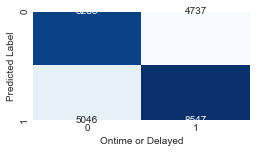

In [23]:
mat = confusion_matrix(test_y, predicted1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Ontime or Delayed')
plt.ylabel('Predicted Label');

In [37]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [1],
             'binarize': [0],
             'fit_prior': [True, False]}
grid = GridSearchCV(BernoulliNB(), param_grid, cv = 7)
grid.fit(train_x, train_y)
print(grid.best_params_)
model2 = BernoulliNB(alpha = 1, binarize = 0, fit_prior = True)
model2.fit(train_x, train_y);
predicted2 = model2.predict(test_x)
model2.score(test_x, test_y)

{'alpha': 1, 'binarize': 0, 'fit_prior': True}


0.594785483507401

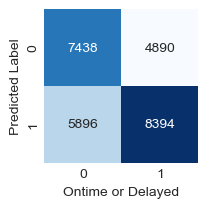

In [38]:
mat = confusion_matrix(test_y, predicted2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Ontime or Delayed')
plt.ylabel('Predicted Label');

In [39]:
from sklearn.naive_bayes import MultinomialNB
param_grid = {'alpha': [1],
             'fit_prior': [True, False]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv = 10)
grid.fit(train_x, train_y)
print(grid.best_params_)
model2 = MultinomialNB(fit_prior = False)
model2.fit(train_x, train_y);
predicted2 = model2.predict(test_x)
model2.score(test_x, test_y)

{'alpha': 1, 'fit_prior': False}


0.59151701855887

In [40]:
model2.score(train_x, train_y)

0.5977458438996901

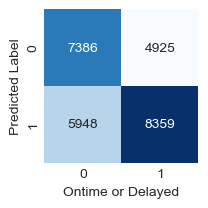

In [41]:
mat = confusion_matrix(test_y, predicted2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Ontime or Delayed')
plt.ylabel('Predicted Label');

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
# param_grid = {'kernel': ['rbf', 'poly', 'precomputed', 'linear'],
#              'C': [1, 5, 10, 50],
#              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
# grid = GridSearchCV(SVC(), param_grid)
# %time grid.fit(train_x, train_y)
# print(grid.best_params_)
model3 = SVC(kernel='linear', gamma = 'auto', C=1E10) #set max iteration time to end program 
model3.fit(train_x, train_y)
predicted3 = model3.predict(test_x)
model3.score(test_x, test_y)

In [ ]:
mat = confusion_matrix(test_y, predicted3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Ontime or Delayed')
plt.ylabel('Predicted Label')

In [42]:
from sklearn.neighbors import KNeighborsClassifier
# param_grid = {'n_neighbors': [4, 5, 6, 7, 8],
#               'p': [1, 2, 3],
#              'leaf_size': [20, 30, 40]}
# grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5)
# %time grid.fit(train_x, train_y)
# print(grid.best_params_)
model4 = KNeighborsClassifier(n_neighbors = 9, p = 2, leaf_size = 30, n_jobs = -1) # imporve the efficiency: set small leaf_size and use all processors
model4.fit(train_x, train_y);
predicted4 = model4.predict(test_x)
model4.score(test_x, test_y)

0.5996693966488842

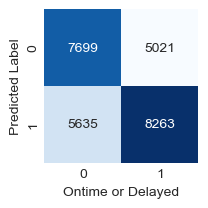

In [43]:
mat = confusion_matrix(test_y, predicted4)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Ontime or Delayed')
plt.ylabel('Predicted Label');

In [21]:
from sklearn.ensemble import RandomForestClassifier
model5 = RandomForestClassifier(random_state = 1, n_estimators = 150, max_features = 50, max_depth = 30)
model5.fit(train_x, train_y)
predicted5 = model5.predict(test_x)
model5.score(test_x, test_y)

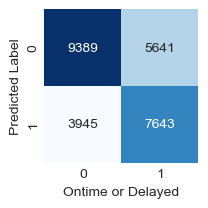

In [49]:
mat = confusion_matrix(test_y, predicted5)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Ontime or Delayed')
plt.ylabel('Predicted Label');

In [50]:
from sklearn.metrics import roc_auc_score
probabilities = model5.predict_proba(test_x)
roc_auc_score(test_y, probabilities[:, 1])

0.6852189713233399

In [51]:
from sklearn.metrics import precision_score

train_predictions = model5.predict(train_x)
precision_score(train_y, train_predictions)

0.9931622618315918

In [52]:
from sklearn.metrics import recall_score

recall_score(train_y, train_predictions)
df_clean.shape

(133088, 656)

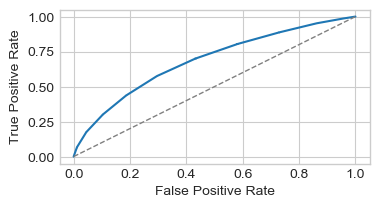

In [54]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [25]:
pred1 = pd.DataFrame(columns=df_clean.columns)
pred1 = pred1.drop(["DEPARTURE_DELAY"], axis = 1)
pred1 = pred1.append({"DATE_27":1,
              "AIRLINE_NK":1,
              "ORIGIN_AIRPORT_BOS":1,
              "DESTINATION_AIRPORT_MCO":1,
              "SCHEDULED_DEPARTURE":19,
              "SCHEDULED_TIME":180},ignore_index=True)
pred1 = pred1.fillna(0)
pred1.shape

(1, 655)

In [57]:
model5.predict_proba(pred1)[0][0] ## the on-time probablity of Spirit from BOS to MCO on 11.27 19:00

ValueError: Number of features of the model must match the input. Model n_features is 655 and input n_features is 656 

In [ ]:

pred2 = pd.DataFrame(columns=df_clean.columns)
pred2 = pred2.drop(["DEPARTURE_DELAY"], axis = 1)
pred2 = pred2.append({
              "AIRLINE_B6":1,
              "ORIGIN_AIRPORT_BOS":1,
              "DESTINATION_AIRPORT_DFW":1,
              "SCHEDULED_DEPARTURE":14,
              "SCHEDULED_TIME":275},ignore_index=True)
pred2 = pred2.fillna(0)
pred2

In [ ]:
model5.predict_proba(pred2)[0][0] ## the on-time probablity of JetBlue from BOS to DFW on 11.27 14:00

In [ ]:
pred3 = pd.DataFrame(columns=df_clean.columns)
pred3 = pred3.drop(["DEPARTURE_DELAY"], axis = 1)
pred3 = pred3.append({
              "AIRLINE_AA":1,
              "ORIGIN_AIRPORT_BOS":1,
              "DESTINATION_AIRPORT_ORD":1,
              "SCHEDULED_DEPARTURE":5,
              "SCHEDULED_TIME":180},ignore_index=True)
pred3 = pred3.fillna(0)
pred3

In [ ]:
model5.predict_proba(pred3)[0][0] ## the on-time probablity of American Airline from BOS to ORD on 11.27 5:00